In [1]:
import sympy as sp
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
t, beta, omega, F, Omega = sp.symbols('t beta omega F Omega')
x = sp.Function('x')
diff_eq = sp.Eq(x(t).diff(t, 2) + beta*x(t).diff(t) + omega * x(t), F * sp.cos(Omega * t))
diff_eq

Eq(beta*Derivative(x(t), t) + omega*x(t) + Derivative(x(t), (t, 2)), F*cos(Omega*t))

In [3]:
beta_val, omega_val, F_val, Omega_val = sp.Rational(1, 8), 0.5, 1, 1
beta_val_float = 1/8
x_eq = diff_eq.subs([(beta, beta_val), (omega, omega_val), (F, F_val), (Omega, Omega_val)])
x_eq

Eq(0.5*x(t) + Derivative(x(t), t)/8 + Derivative(x(t), (t, 2)), cos(t))

In [4]:
ics = {x(0): 3, x(t).diff(t).subs(t, 0): 0}
oscillator_sol = sp.dsolve(x_eq, x(t), ics=ics)
oscillator_sol

Eq(x(t), (-0.234888487786618*sin(0.70433922934904*t) + 4.88235294117647*cos(0.70433922934904*t))*exp(-0.0625*t) + 0.470588235294118*sin(t) - 1.88235294117647*cos(t))

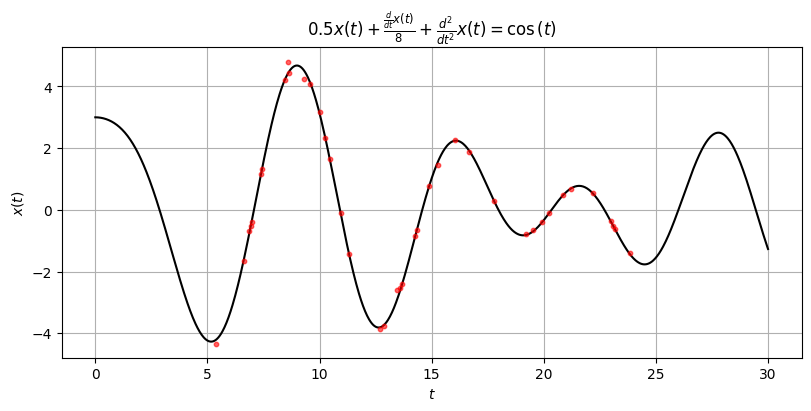

In [5]:
t_max = 30
t_values = np.linspace(0, t_max, 1001)
oscillator_function = sp.lambdify(t, oscillator_sol.rhs, 'numpy')

datapoints = {'t': np.random.uniform(5, 25, 40)}
datapoints['x'] = (x_true := oscillator_function(datapoints['t'])) + np.random.normal(0, np.abs(x_true) * 0.05)

figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 4))
axes.plot(t_values, oscillator_function(t_values), color='black')
axes.scatter(datapoints['t'], datapoints['x'], color='red', zorder=10, alpha=0.6, s=10)
# axes.grid()
axes.set(xlabel='$t$', ylabel='$x(t)$',
         title=f'${sp.latex(x_eq)}$')
axes.grid();

In [6]:
class ModularNeuralNetwork(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 output_size: int, 
                 layer_sizes: tuple[int] = (), 
                 activation_function: nn.modules.activation = nn.Tanh()):
        super(ModularNeuralNetwork, self).__init__()
        if len(layer_sizes) == 0:
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=output_size),
                activation_function
            )
        elif len(layer_sizes) == 1:
            size = layer_sizes[0]
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=size),
                activation_function,
                nn.Linear(in_features=size, out_features=output_size),
                activation_function
            )
        else:
            layers = []
            for index, layer_size in enumerate(layer_sizes):
                if index == 0:
                    layer = nn.Linear(in_features=input_size, out_features=layer_size)
                else:
                    layer = nn.Linear(in_features=layer_sizes[index - 1], 
                                      out_features=layer_size)
                layers += [layer, activation_function]
            layers += [nn.Linear(in_features=layer_sizes[-1], 
                                 out_features=output_size)]
            self.layers = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
epochs = 30000
learning_rate = 0.005
hidden_layers = 300, 300, 300
NN = ModularNeuralNetwork(input_size=1,
                          output_size=1,
                          layer_sizes=hidden_layers,
                          activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_nn = np.zeros(epochs)
NN.train()
for epoch in range(epochs):
    y_pred = NN(X)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_nn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 5.281951427459717
Epoch 1000, Loss: 0.412695974111557
Epoch 2000, Loss: 0.12181563675403595
Epoch 3000, Loss: 0.11353080719709396
Epoch 4000, Loss: 0.0035320245660841465
Epoch 5000, Loss: 0.007002682890743017
Epoch 6000, Loss: 0.019488682970404625
Epoch 7000, Loss: 0.042049702256917953
Epoch 8000, Loss: 0.010173548944294453
Epoch 9000, Loss: 0.05074974521994591
Epoch 10000, Loss: 0.007736931089311838
Epoch 11000, Loss: 0.009658792987465858
Epoch 12000, Loss: 0.0051199160516262054
Epoch 13000, Loss: 0.009849313646554947
Epoch 14000, Loss: 0.026042643934488297
Epoch 15000, Loss: 0.010716244578361511
Epoch 16000, Loss: 0.01719876192510128
Epoch 17000, Loss: 0.01069385465234518
Epoch 18000, Loss: 0.10673341900110245
Epoch 19000, Loss: 0.08775818347930908
Epoch 20000, Loss: 0.023117972537875175
Epoch 21000, Loss: 0.009972450323402882
Epoch 22000, Loss: 0.024963414296507835
Epoch 23000, Loss: 0.009764759801328182
Epoch 24000, Loss: 0.03540424630045891
Epoch 25000, Loss: 0.0113

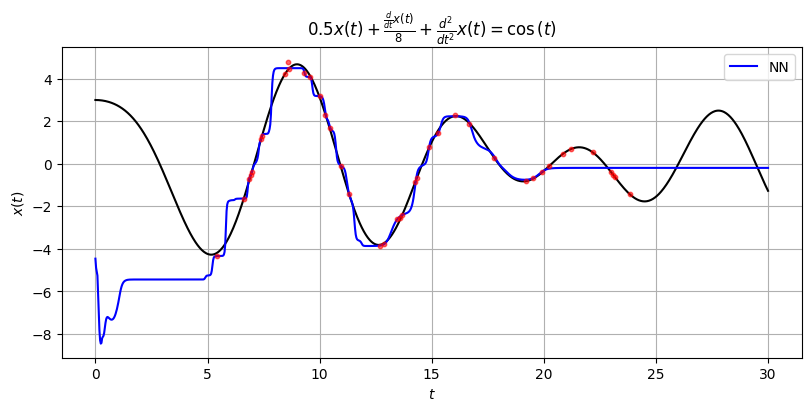

In [8]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 4))
axes.plot(t_values, oscillator_function(t_values), color='black')
axes.scatter(datapoints['t'], datapoints['x'], color='red', zorder=10, alpha=0.6, s=10)
t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='blue', label='NN')
axes.legend()
axes.set(xlabel='$t$', ylabel='$x(t)$',
         title=f'${sp.latex(x_eq)}$')
axes.grid();

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
epochs = 30000
learning_rate = 0.005
hidden_layers = 300, 300, 300
NN_reg = ModularNeuralNetwork(input_size=1,
                          output_size=1,
                          layer_sizes=hidden_layers,
                          activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(NN_reg.parameters(), lr=learning_rate, weight_decay=0.02)
criterion = nn.MSELoss()
loss_array_nn = np.zeros(epochs)
NN_reg.train()
for epoch in range(epochs):
    y_pred = NN_reg(X)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_nn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 5.165194511413574
Epoch 1000, Loss: 5.127195835113525
Epoch 2000, Loss: 0.19448989629745483
Epoch 3000, Loss: 0.17020702362060547
Epoch 4000, Loss: 0.175019308924675
Epoch 5000, Loss: 0.17631977796554565
Epoch 6000, Loss: 0.22483964264392853
Epoch 7000, Loss: 0.5506865382194519
Epoch 8000, Loss: 0.6701248288154602
Epoch 9000, Loss: 0.15824586153030396
Epoch 10000, Loss: 0.14122849702835083
Epoch 11000, Loss: 0.397697776556015
Epoch 12000, Loss: 0.29340943694114685
Epoch 13000, Loss: 0.7873122096061707
Epoch 14000, Loss: 0.1742583066225052
Epoch 15000, Loss: 1.1829206943511963
Epoch 16000, Loss: 0.5066943764686584
Epoch 17000, Loss: 0.16301564872264862
Epoch 18000, Loss: 0.32456907629966736
Epoch 19000, Loss: 0.5774931311607361
Epoch 20000, Loss: 0.31142881512641907
Epoch 21000, Loss: 0.1426117718219757
Epoch 22000, Loss: 0.14724452793598175
Epoch 23000, Loss: 0.3048613965511322
Epoch 24000, Loss: 0.1394473761320114
Epoch 25000, Loss: 0.13401193916797638
Epoch 26000, Loss

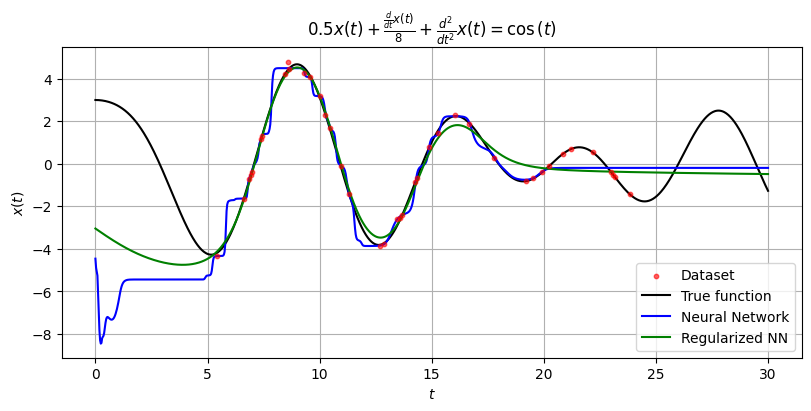

In [12]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 4))
axes.scatter(datapoints['t'], datapoints['x'], color='red', zorder=10, alpha=0.6, s=10, label='Dataset')
axes.plot(t_values, oscillator_function(t_values), color='black', label='True function')
t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='blue', label='Neural Network')
axes.plot(t_val_tensor, NN_reg(t_val_tensor.cuda()).cpu().detach(), color='green', label='Regularized NN')
axes.legend()
axes.set(xlabel='$t$', ylabel='$x(t)$',
         title=f'${sp.latex(x_eq)}$')
axes.grid();

In [14]:
figure.savefig('./ThesisGraphics/Regularization.png')

In [16]:
import graphviz

def create_mlp_graph():
    dot = graphviz.Digraph()

    # Define the direction of the graph
    dot.attr(rankdir='LR')

    # Define the nodes for the input layer
    dot.node('input1', 'Input 1', shape='circle', style='filled', color='lightblue')
    dot.node('input2', 'Input 2', shape='circle', style='filled', color='lightblue')
    dot.node('input3', 'Input 3', shape='circle', style='filled', color='lightblue')

    # Define the nodes for the hidden layer
    dot.node('hidden1', 'Hidden 1', shape='circle', style='filled', color='lightgreen')
    dot.node('hidden2', 'Hidden 2', shape='circle', style='filled', color='lightgreen')

    # Define the node for the output layer
    dot.node('output', 'Output', shape='circle', style='filled', color='lightcoral')

    # Add edges between the input layer and the hidden layer
    dot.edge('input1', 'hidden1')
    dot.edge('input1', 'hidden2')
    dot.edge('input2', 'hidden1')
    dot.edge('input2', 'hidden2')
    dot.edge('input3', 'hidden1')
    dot.edge('input3', 'hidden2')

    # Add edges between the hidden layer and the output layer
    dot.edge('hidden1', 'output')
    dot.edge('hidden2', 'output')

    return dot

# Create the MLP graph
mlp_graph = create_mlp_graph()

# Render and view the graph (optional)
mlp_graph.render(filename='mlp_graph', format='png', cleanup=True)
mlp_graph.view()


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH